<h1 align=center><font size = 6.5>INDIAN RESTAURANT IN TORONTO - A DATA SCIENCE APPROACH</font></h1>

This report will try to address the following question for any entrepreneur who is planning to invest in opening a new India restaurant in Toronto city. 
1. How many Indian restaurants are already present in Toronto City?
2. Which neighbourhoods in Toronto city has an Indian restaurant?
3. Which neighbourhoods in Toronto city will be ideal to start a new India Restaurant?
4. What are the descriptive highlights of these ideal neighbourhoods?

With these questions addressed, an entrepreneur will have a fair idea on where to start his business.

# Table of content

1. Table of Postal Codes - Web Scraping & creating Dataframe.
2. Lat Long for Neighbourhood - Dataframe.
3. Extracting the venues of all Neighbourhood using Foursquare API.
4. Exploratory Data Analysis.
5. Clustering the Neighbourhoods
6. Analyssng clusters

Importing required Libraries for this study

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [5]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [6]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


# 1. Table of Postal Codes - Web Scraping & creating Dataframe.

The study for this report starts with exploring the geography of Toronto. For this, we need to understand the defined Postal codes of Toronto. Each postal code is assigned to a Borough. A Borough is defined as an area within a city which is either made of a single or multiple neighbourhoods. A list of all the postal codes with assigned Boroughs and neighbourhoods is available on a wiki page.

We shall be using pandas to read the wiki page link "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" as html. 'dfl' declares all the tables in the html page as dataframes. Amoung all the tables in the html, df is defined as the postal code table. Dataframe "df" has all the details of 'Postal Codes', 'Borough' and 'Nieghbourhoods' in Toronto city. The following data manipulation has been done to arrive at the final df table

1. Ensured there is no 'Not assigned' Nieghbourhood in the data frame.
2. All the Borough with Not assigned values are dropped from the dataframe.
3. Index is reset.
Extracting data from wiki page as a dataframe.

In [3]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
dfl = pd.read_html(wiki_url)
df = dfl[0]

Ignore cells with a borough that is Not assigned.

In [4]:
df.replace('Not assigned',np.nan,inplace=True)
df.dropna(axis=0,inplace=True)

Combining Neighbourhood with same Postal Code

In [6]:
result = df.groupby(['Postal Code','Borough'], sort=False).agg( ', '.join)
df_new=result.reset_index()
df_new.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


# 2. Lat Long for Neighbourhood - Dataframe

Extracting the geographical coordinates of each postal code from the csv file @ http://cocl.us/Geospatial_data

In [8]:
df_latlon = pd.read_csv("http://cocl.us/Geospatial_data")
df_latlon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the postal code and geographical coordinates for neighbourhoods

In [9]:
canada_df = pd.merge(df_new, df_latlon, on='Postal Code')
Toronto_data = canada_df[canada_df['Borough'].isin(['East Toronto', 'Downtown Toronto', 'West Toronto', 'Central Toronto'])].reset_index(drop=True)
Toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


The above dataset contains the postal code, Borough, Neighbourhoods and Latitudes and longitude details of the neighbourhoods in the following Borough of Tronto city rather than that of entire canada. 
1. East Toronto
2. Downtown Toronto
3. West Toronto
4. Central Toronto

### Plotting Neighbourhoods of Toronto on the Map.

The "Toronto_data" is used to superimpose the neighbourhoods on the map of Toronto city using Folium library. For this, first, the geocodes for Toronto city is identified.

In [10]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


Once the geocodes of Toronto City are explored, Folium library is used to superimpose the neighbourhoods on the map of Toronto city.

In [11]:
# create map of Toronto City using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# 3.Extracting the venues of one Neighbourhood using Foursquare API.

The venue data details all types of venues, their category and geo-coordinates for any desired location. For this study, the venue data was extracted using the Foursquare API. For this, first, the Foursquare API client credentials needs to be established. For this project, I'm using my Foursquare API credentials.

In [12]:
CLIENT_ID = 'ELAXVPSFXWALETAHQEOOH4C3KFTR0H04HURJZ4ENESZIMYXF' # your Foursquare ID
CLIENT_SECRET = 'W34MJTHDYYLQ55LYA2BCADHBOKIOPEL0HF4AXPZPZUPKFRK1' # your Foursquare Secret
VERSION = '20201104' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ELAXVPSFXWALETAHQEOOH4C3KFTR0H04HURJZ4ENESZIMYXF
CLIENT_SECRET:W34MJTHDYYLQ55LYA2BCADHBOKIOPEL0HF4AXPZPZUPKFRK1


### Extracting venues for one Neighbourhood from Toronto_data.

In [13]:
Neigh1 = Toronto_data.loc[0, 'Neighbourhood']
Neigh1

'Regent Park, Harbourfront'

For extracting the venues we would require Geocodes which we have for these neighbourhoods.

In [14]:
Neigh1_latitude = Toronto_data.loc[0, 'Latitude'] # neighbourhood latitude value
Neigh1_longitude = Toronto_data.loc[0, 'Longitude'] # neighbourhood longitude value

Neigh1_name = Toronto_data.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(Neigh1_name, 
                                                               Neigh1_latitude, 
                                                               Neigh1_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


Getting the url set for Foursquare API

In [15]:
# type your answer here
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Neigh1_latitude, 
    Neigh1_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ELAXVPSFXWALETAHQEOOH4C3KFTR0H04HURJZ4ENESZIMYXF&client_secret=W34MJTHDYYLQ55LYA2BCADHBOKIOPEL0HF4AXPZPZUPKFRK1&v=20201104&ll=43.6542599,-79.3606359&radius=500&limit=100'

Getting the top 100 venues of the neighbourhoods with a radius of 500 mtrs. This done by "get" request. The API will return a .json file. We shall extract the venues for the first neighbourhood from the same .json file.

In [16]:
results = requests.get(url).json()

We need to create a function that will extraxt the categories from the .json file declared as "results".

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The above function is used to create a dataframe with all the list of the following

1. Venue Name
2. Venue Category
3. Venue location latitude
4. Venue location longitude

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Impact Kitchen,Restaurant,43.656369,-79.356980
4,Body Blitz Spa East,Spa,43.654735,-79.359874


### Extracting the venues of all Neighbourhood using Foursquare API.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighbourhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [23]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1624, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


To analyse the venues across all neighbourhood, a suitable dataframe needs to be created showing the presence of each category of venue in each neighbourhood. For this, the data needs to be transformed as follows.

In [24]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# 4. Exploratory Data Analysis.

Now that all the required data is extracted, few data exploration can be done as followes

#### 1. Identifying total number of venues categories in each Neighbourhood.
For this we will have to use the Toronto_venues data frame. We will have to group the rows will same neighbourhoods and take a sum of the venues in each neighbourhoods. The set of code below explains the same. 

In [27]:
venue_count = Toronto_venues.groupby('Neighbourhood').count()
venue_count.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68


In [28]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


#### 2. Frequency of Occurrence of venue categories in each Neighbourhood. 
This can be deduced by using already transformed Toronto_onehot data frame using the following code.

In [29]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,0.0,0.0,0.018182,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.018182,0.036364,0.0,0.000000,0.0,0.018182,0.018182,0.0,0.036364,0.0,0.0,0.018182,0.0000,0.000000,0.0000,0.0,0.018182,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.018182,0.0,0.0,0.0,0.0,0.036364,0.0,0.0,0.0,0.000000,0.0,0.036364,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.000000,0.018182,0.000000,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.018182,0.000000,0.0,0.018182,0.000000,0.0,0.0,0.0,0.000000,0.0,0.018182,0.0,0.0,0.0,0.0,0.000000,0.036364,0.0000,0.0,0

In [30]:
Toronto_grouped.shape

(39, 237)

There are 237 venue categories in total spread across 39 Neighbourhoods. The numbers shows the frequency of occurrence of each of these venue category in the neighbourhoods. 

#### 3. Identifying Indian Resturants amoung venues in Toronto.
From the Toronto_venues data above, we can filter out the INDIAN RESTAURANT alone(using count instead of mean) to understand the following
1. Number of Indian restaurants in Toronto city.
2. The Neighbourhoods in which the existing Indian Resturants are present.

The table below shows the list of all the Neighbourhoods which has Indian Restaurant and also the count of resturant in each.

In [37]:
Indian_Res = Toronto_venues[Toronto_venues['Venue Category'] == 'Indian Restaurant']
Indian_Res = Indian_Res.groupby('Neighbourhood').count().reset_index()
Indian_Res = Indian_Res[['Neighbourhood','Venue' ]]
Indian_Res

,Neighbourhood,Venue
0,Central Bay Street,1
1,Church and Wellesley,1
2,Davisville,1
3,"Harbourfront East, Union Station, Toronto Islands",1
4,"St. James Town, Cabbagetown",1
5,"The Annex, North Midtown, Yorkville",1
6,"The Danforth West, Riverdale",1


In [38]:
Indian_Res.shape

(7, 2)

There are in total only 7 Indian Restaurants spread across 7 neighbourhoods in Toronto City. This tell us that there is a very good chance of having a good business from Indian resturant if it's opened in any other neighbourhood. 

#### 4. Frequency of occurrence of Indian Resturants in neighbourhoods.

In [42]:
Toronto_grouped1 = Toronto_grouped[['Neighbourhood','Indian Restaurant']]
Toronto_grouped1.head()

,Neighbourhood,Indian Restaurant
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.014706


#### 5. Top 10 Occurring venues in each Neighbourhood
The below set of codes and outputs are intendended to identify the top 10 occuring vennues in each Neighbourhood. For this first a function is developed to sort the categories of venue for each neighbourhood based on their frequency of occurance. We would need this information to understand the suitability of Neighbourhoods for opening an Indian Resturant.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Seafood Restaurant,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Bakery,Sandwich Place,Department Store
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Park,Pizza Place,Light Rail Station,Skate Park,Burrito Place,Farmers Market,Fast Food Restaurant,Butcher,Restaurant,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Plane,Coffee Shop,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Department Store,Burger Joint,Japanese Restaurant,Thai Restaurant


# 5. Clustering the Neighbourhoods

In this section, the grouped data for each neighbourhood will be used to identify Neighbourhoods in Toronto city. Following lists the steps involved in Clusturing.

1. K-means method will be used to cluster the Neighbourhoods.
2. Clusters will be identified
3. Clusters will be plotted on the map of Toronto using Folium library.
4. Each cluster's properties will be identified in terms of the kind of venues present in them.

#### Running K-means to cluster the grouped data and identifying the clusters.

In [43]:
# set number of clusters
kclusters = 4

Toronto_grouped_clustering = Toronto_grouped1.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 3, 0, 3, 0, 2, 0], dtype=int32)

Adding the cluster details to the Toronto_sorted dataset to identify the nature of each cluster.

In [44]:
# add clustering labels
Toronto_grouped1.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(Toronto_grouped1.set_index('Neighbourhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.0
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0.0
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.0
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0.0
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.0


Visualising the clusters by plotted them on the map of Toronto using Folium library.

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We have created 4 clusters of neighbourhoods of Tronto based on the frequency of presence of an Indian resturants in them

# 6. Analysing clusters

In this section, data related to each cluster will be studied to identify its properties. There are 4 clusters created, hence there will be 4 parts of analysis.

#### 1. Distribution of Neighbourhood across clusters

In [46]:
Plot1 = Toronto_merged[["Neighbourhood","Cluster Labels"]]
Plot1 = Plot1.groupby('Cluster Labels').count().reset_index()
Plot1

,Cluster Labels,Neighbourhood
0,0,32
1,1,1
2,2,3
3,3,3


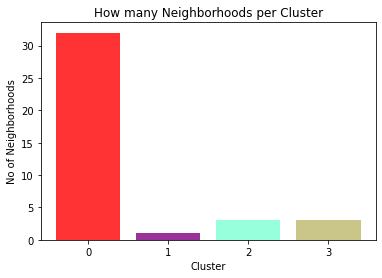

In [47]:
import matplotlib.pyplot as plt 
objects = (0,1,2,3)
Y = np.arange(len(objects))
X = Plot1['Neighbourhood']
plt.bar(Y,X,align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(Y, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')
plt.show()

#### 2. Distribution of Indian Resturant across Clusters

In [48]:
# add clustering labels
Toronto_grouped2.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged2 = Toronto_data

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged2 = Toronto_merged2.join(Toronto_grouped2.set_index('Neighbourhood'), on='Neighbourhood')

Toronto_merged2.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0


In [49]:
Plot2 = Toronto_merged2[["Indian Restaurant","Cluster Labels"]]
Plot2 = Plot2.groupby('Cluster Labels').sum().reset_index()
Plot2

,Cluster Labels,Indian Restaurant
0,0,0
1,1,1
2,2,3
3,3,3


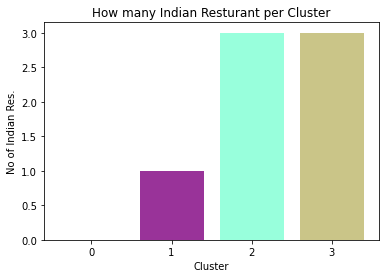

In [50]:
Z = Plot2['Indian Restaurant']
plt.bar(Y,Z,align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(Y, objects)
plt.ylabel('No of Indian Res.')
plt.xlabel('Cluster')
plt.title('How many Indian Resturant per Cluster')
plt.show()

#### 3. Cluster 0 Analysis

In [51]:
C1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1,2] + list(range(5, Toronto_merged.shape[1]))]]
C1.head()

,Borough,Neighbourhood,Cluster Labels,Indian Restaurant
0,Downtown Toronto,"Regent Park, Harbourfront",0,0.0
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0,0.0
2,Downtown Toronto,"Garden District, Ryerson",0,0.0
3,Downtown Toronto,St. James Town,0,0.0
4,East Toronto,The Beaches,0,0.0


In [52]:
print(C1.shape)
C1.Borough.unique()

(32, 4)


array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

Cluster 0 has no Indian restaurants in it. It is spread across all 4 Borough ie 'Downtown Toronto', 'East Toronto', 'West Toronto' and 'Central Toronto'. This can be an Ideal cluster for setting up an Indian Restaurant as there is no competition present in the same. Let us try to find an ideal neighbourhood in this cluster for our restarant.

Finding top 10 most occuring venues in cluster 0 neighbourhoods

In [54]:
# add clustering labels (all) to to 10 venue data. 
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_merged1 = Toronto_data
Toronto_merged1 = Toronto_merged1.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
Toronto_merged1.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Electronics Store,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Neighborhood,Pub,Health Food Store,Trail,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


In [56]:
# Filtering cluster 0 data alone for top 10 venues
P1 = Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 0, Toronto_merged1.columns[[1,2] + list(range(6, Toronto_merged1.shape[1]))]]
P1.head()

,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Electronics Store,Spa,Beer Store
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,Downtown Toronto,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
3,Downtown Toronto,St. James Town,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
4,East Toronto,The Beaches,Neighborhood,Pub,Health Food Store,Trail,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


### The above data frame shows the top 10 venues for each neighbourhoods in cluster 0.

Within the above dataset we can also identify the neighbourhoods which has more number of Parks or bars as these neighbourhoods would be most suitable for Indian restaurants. 

In [57]:
My_Neigh = P1[P1['1st Most Common Venue'] == 'Park']
My_Neigh.head()

,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,East Toronto,"India Bazaar, The Beaches West",Park,Gym,Sushi Restaurant,Sandwich Place,Liquor Store,Burrito Place,Restaurant,Italian Restaurant,Fast Food Restaurant,Fish & Chips Shop
18,Central Toronto,Lawrence Park,Park,Swim School,Bus Line,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
20,Central Toronto,Davisville North,Park,Hotel,Breakfast Spot,Sandwich Place,Food & Drink Shop,Dog Run,Dance Studio,Department Store,Gym / Fitness Center,Cosmetics Shop
21,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",Park,Sushi Restaurant,Jewelry Store,Trail,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
33,Downtown Toronto,Rosedale,Park,Trail,Playground,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [59]:
My_Neigh1 = P1[P1['1st Most Common Venue'] == 'Bar']
My_Neigh1.head()

,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,West Toronto,"Little Portugal, Trinity",Bar,Coffee Shop,Vietnamese Restaurant,Restaurant,Café,Asian Restaurant,Men's Store,Cuban Restaurant,Record Shop,Pizza Place


#### 4. Cluster 1 Analysis

In [60]:
C2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1,2] + list(range(5, Toronto_merged.shape[1]))]]
C2

,Borough,Neighbourhood,Cluster Labels,Indian Restaurant
24,Central Toronto,"The Annex, North Midtown, Yorkville",1,0.052632


Cluster 1 is present in only 1 borough ie Central Toronto. Since there is only 2 neighbourhoods in this cluster and with 1 Indian Restaurant already present in it, its not an ideal choise for us to open another Indian Restaurent here. 

#### 5. Cluster 2 Analysis

In [61]:
C3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1,2] + list(range(5, Toronto_merged.shape[1]))]]
C3

,Borough,Neighbourhood,Cluster Labels,Indian Restaurant
12,East Toronto,"The Danforth West, Riverdale",2,0.023256
26,Central Toronto,Davisville,2,0.030303
35,Downtown Toronto,"St. James Town, Cabbagetown",2,0.020833


Cluster 2 is present in only 3 borough and is spread across 5 neighbourhoods. With 3 Indian Restaurant already present in it, its not an ideal choise for us to open another Indian Restaurent here.

#### 6. Cluster 3 Analysis

In [62]:
C4 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1,2] + list(range(5, Toronto_merged.shape[1]))]]
C4

,Borough,Neighbourhood,Cluster Labels,Indian Restaurant
6,Downtown Toronto,Central Bay Street,3,0.014706
10,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",3,0.010000
37,Downtown Toronto,Church and Wellesley,3,0.013333


Cluster 3 is present in only 3 borough and is spread across 5 neighbourhoods. With 3 Indian Restaurant already present in it, its not an ideal choise for us to open another Indian Restaurent here.

## Hence only cluster 0 spread across 32 neighbourhoods and with no existing Indian Restaurant present in it is the ideal choise to start a new Indian Restaurant. Also, neighbourhoods like India Bazaar, The Beaches West and Little Portugal, Trinity are most suitable neighbourhoods with lots of parks and bars around. 